In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage.filters import convolve

C:\Users\Asus\AppData\Local\Temp\ipykernel_167792\2658830174.py:4: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import convolve


In [3]:
def sobelFilters(image):
    sobel_kx = np.array([[-1, 0, 1],
                         [-2, 0, 2],
                         [-1, 0, 1]], np.float32)
    sobel_ky = np.array([[1, 2, 1],
                         [0, 0, 0],
                         [-1, -2, -1]], np.float32)

    gx = cv2.filter2D(image, -1, sobel_kx)
    gy = cv2.filter2D(image, -1, sobel_ky)
    g = np.power((gx**2 + gy**2), 1/2)
    theta = np.arctan(gy/gx)
    return g, theta

In [4]:
def nonMaxSuppression(g, theta):
    M, N = g.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = theta * 180. / np.pi
    angle[angle < 0] += 180


    for i in range(1, M-1):
        for j in range(1, N-1):
            q = 255
            r = 255
            #angle 0
            if 0 <= angle[i,j] < 22.5 or 157.5 <= angle[i,j] <= 180:
                q = g[i, j+1]
                r = g[i, j-1]
            #angle 45
            elif 22.5 <= angle[i, j] < 67.5:
                q = g[i+1, j-1]
                r = g[i-1, j+1]
            #angle 90
            elif 67.5 <= angle[i, j] < 112.5:
                q = g[i+1, j]
                r = g[i-1, j]
            #angle 135
            elif 112.5 <= angle[i, j] < 157.5:
                q = g[i-1, j-1]
                r = g[i+1, j+1]
            if g[i,j] >= q and g[i, j] >= r:
                Z[i, j] = g[i, j]
            else:
                Z[i, j] = 0
    return Z

In [5]:
def threshold(image, weakPixel, strongPixel, lowThreshold, highThreshold):
    highThreshold = image.max() * highThreshold
    lowThreshold = highThreshold * lowThreshold

    M, N = image.shape

    res = np.zeros((M,N), dtype=np.int32)

    weak = np.int32(weakPixel)

    strong = np.int32(strongPixel)
    strongI, strongJ = np.where(image >= highThreshold)

    weakI, weakJ = np.where((image <= highThreshold) & (image >= lowThreshold))

    res[strongI, strongJ] = strong
    res[weakI, weakJ] = weak

    return res

In [6]:
def hysteresis(image, weakPixel, strongPixel):
    M, N = image.shape
    weak = weakPixel
    strong = strongPixel
    for i in range(1, M-1):
        for j in range(1, N-1):
            if image[i, j] == weak:
                if ((image[i + 1, j - 1] == strong) or (image[i + 1, j] == strong) or (image[i + 1, j + 1] == strong)
                        or (image[i, j - 1] == strong) or (image[i, j + 1] == strong)
                        or (image[i - 1, j - 1] == strong) or (image[i - 1, j] == strong) or (image[i - 1, j + 1] == strong)):
                    image[i, j] = strong
                else:
                    image[i, j] = 0

    return image

In [7]:
def cannyDetection(image, sigma, weakPixel, strongPixel, lowThreshold, highThreshold):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image = cv2.GaussianBlur(image, (5, 5), sigma)
    gradient, theta = sobelFilters(image)
    nonMaxImage = nonMaxSuppression(gradient, theta)
    thresholdImage = threshold(nonMaxImage, weakPixel, strongPixel, lowThreshold, highThreshold)

    return hysteresis(thresholdImage, weakPixel, strongPixel)

In [8]:
def showImage(image, title=None):
    """
    Showing custom image with title
    :param image: Custom image
    :param title: Custom title
    :return: Image plot with title
    """
    plt.figure(figsize=(12, 12))
    plt.imshow(image)
    plt.title(title)
    plt.show()

In [9]:
highThresholdRatio = 0.15
lowThresholdRatio = 0.05
sigma = 1.4
weakPixel = 100
strongPixel = 255

In [10]:
image = cv2.imread('images\\2.jpg', cv2.IMREAD_COLOR)
cannyImage = cannyDetection(image, sigma, weakPixel, strongPixel, lowThresholdRatio, highThresholdRatio)

C:\Users\Asus\AppData\Local\Temp\ipykernel_167792\2004410340.py:12: RuntimeWarning: divide by zero encountered in true_divide
  theta = np.arctan(gy/gx)
C:\Users\Asus\AppData\Local\Temp\ipykernel_167792\2004410340.py:12: RuntimeWarning: invalid value encountered in true_divide
  theta = np.arctan(gy/gx)


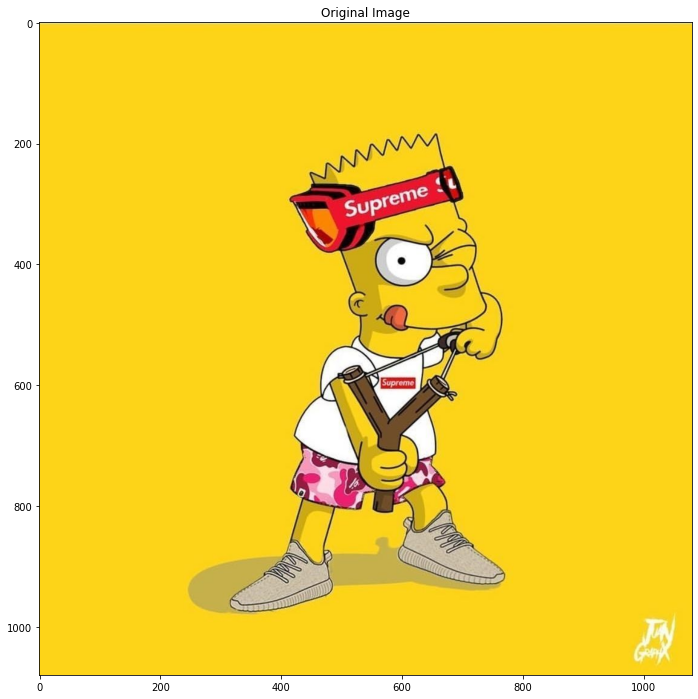

In [11]:
showImage(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), 'Original Image')

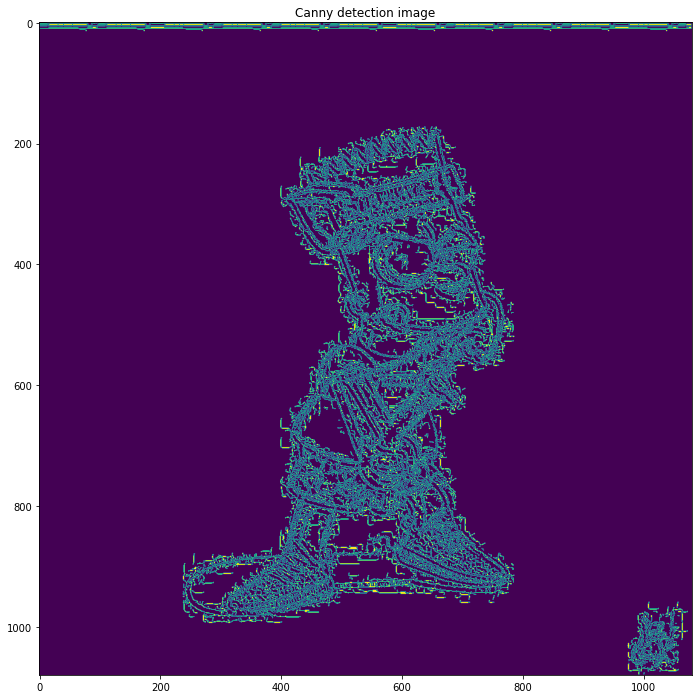

In [12]:
showImage(cannyImage, 'Canny detection image')